In [ ]:
"""
a Google Colab notebook to test the CNN neural network as implemented here:
https://github.com/saikat15010/Brain-Tumor-Detection/blob/main/CNN%20on%20Harvard%20Medical%20Dataset.ipynb
Code in this notebook is copied as closely from the source as possible, except for comments and changes
to the file directory path due to issues specific on my end.
"""

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import warnings
#warnings.filterwarnings("ignore")

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
image_size = [256,256]
# current dir for colab appears to be in the /content folder
data_path = '../gdrive/MyDrive/healthcare research data/Harvard Medical Dataset2'
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
print(image_size+[3])

[256, 256, 3]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
# from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
# Keras must have updated their setup at some point
import numpy as np
tf.keras.backend.clear_session()

In [ ]:
#Initial block of the model

# Sources:
# https://www.tensorflow.org/api_docs/python/tf/distribute/MirroredStrategy
# https://towardsdatascience.com/train-a-neural-network-on-multi-gpu-with-tensorflow-42fa5f51b8af
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

  ini_input=keras.Input(shape=(512,512,3),name="image")

  x1=layers.Conv2D(64,(22,22),strides=2)(ini_input)
  x1=layers.MaxPooling2D((4,4))(x1)
  x1=layers.BatchNormalization()(x1)

  x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
  x2=layers.MaxPooling2D((2,2))(x2)
  x2=layers.BatchNormalization()(x2)

  x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
  x3=layers.MaxPooling2D((2,2))(x3)
  x3=layers.BatchNormalization()(x3)

  # Source: https://github.com/keras-team/keras/issues/11434#issuecomment-509164566
  # Trying to "fix" things by excluding a Conv2D-MaxPooling-BatchNorm block.
  # This will probably hurt the model's performance, but at least I might be able to run it.

  # x4=layers.Conv2D(512,(3,3),strides=2,padding="same")(x3)
  # x4=layers.MaxPooling2D((2,2))(x4)
  # x4=layers.BatchNormalization()(x4)

  x5=layers.GlobalAveragePooling2D()(x3)
  x5=layers.Activation("relu")(x5)

  x6=layers.Dense(1024,"relu")(x5)
  x6=layers.BatchNormalization()(x6)
  x7=layers.Dense(512,"relu")(x6)
  x7=layers.BatchNormalization()(x7)
  x8=layers.Dense(256,"relu")(x7)
  x8=layers.BatchNormalization()(x8)
  x8=layers.Dropout(.2)(x8)
  x9=layers.Dense(2)(x8)
  pred=layers.Activation("softmax")(x9)

  model=keras.Model(inputs=ini_input,outputs=pred)
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 246, 246, 64)      92992     
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 61, 61, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 128)       991360    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 128)       0     

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2)
# maybe changing target size from 224 to 256 helps?
train_generator=train_datagen.flow_from_directory(data_path,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  subset='training',
                                                  # https://github.com/keras-team/keras/issues/11434
                                                  # See the first post for context as to why batch size is 2.
                                                  batch_size=10,
                                                  class_mode='categorical')
val_generator = train_datagen.flow_from_directory(data_path,
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  shuffle=True,
                                                  subset='validation',
                                                  batch_size=10,
                                                  class_mode='categorical')


Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
print(train_generator.n)
print(train_generator.batch_size)
print(242//32)

122
2
7


In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
# The source material says that fit generator is deprecated for this kind of model
# and to use fit(). Reference:
# https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/Model#fit
print(step_size_train)

12


In [ ]:
"""
2023-11-04 23:46:04.261726: F tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:656] Check failed:
cudnnSetTensorNdDescriptor(handle_.get(), elem_type, nd, dims.data(), strides.data()) == CUDNN_STATUS_SUCCESS (3 vs. 0)batch_descriptor:
{count: 10 feature_map_count: 512 spatial: 0 0 value_min: 0.000000 value_max: 0.000000 layout: BatchDepthYX}

UPDATE: Removing one Conv2D-Pooling-BatchNorm from the model made it work.
It seems the issue was caused by too many pooling layers reducing the image to 0x0.
The loss and accuracy performance will surely be different, but it is what it is.
"""
history = model.fit(train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=80,
                    verbose=1,
                    validation_data=val_generator)

Epoch 1/80
12/12 [==============================] - 3s 224ms/step - loss: 0.5113 - accuracy: 0.7321 - val_loss: 0.3352 - val_accuracy: 0.9000
Epoch 2/80
12/12 [==============================] - 2s 188ms/step - loss: 0.5887 - accuracy: 0.6696 - val_loss: 0.3082 - val_accuracy: 0.8333
Epoch 3/80
12/12 [==============================] - 3s 224ms/step - loss: 0.5716 - accuracy: 0.6875 - val_loss: 0.3366 - val_accuracy: 0.9333
Epoch 4/80
12/12 [==============================] - 5s 405ms/step - loss: 0.4979 - accuracy: 0.7500 - val_loss: 0.3746 - val_accuracy: 0.8000
Epoch 5/80
12/12 [==============================] - 3s 197ms/step - loss: 0.5128 - accuracy: 0.7500 - val_loss: 0.2923 - val_accuracy: 0.9667
Epoch 6/80
12/12 [==============================] - 2s 186ms/step - loss: 0.5582 - accuracy: 0.7054 - val_loss: 0.2477 - val_accuracy: 1.0000
Epoch 7/80
12/12 [==============================] - 3s 234ms/step - loss: 0.5419 - accuracy: 0.7054 - val_loss: 0.3628 - val_accuracy: 0.8667
Epoch 

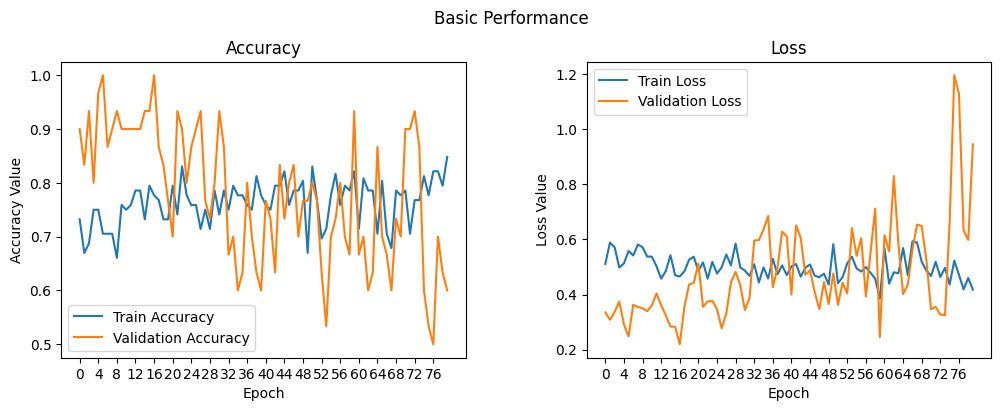

In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,80))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 80, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 80, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Compared to the source material it seems that our attempt at replicating it (after cutting off one Conv2D-MaxPooling-BatchNormalization stack) is either about as good or slightly better.